In [76]:
import sys
import yaml
import time
from pathlib import Path

import pandas as pd
import numpy as np
import connectorx as cx
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# custom
sys.path.append(str(Path('../').resolve()))
from src.pipeline.clients import get_db_client
from src.utils.db_operator import SQLQueryOperator

In [77]:
sql = SQLQueryOperator(config_path='../source_config.yaml')

### Timespan data collection

In [78]:
dates_min_max = sql("""select max(time), min(time) from prod.files_image""")
dates_min_max

Retrieved 1 datapoints in 1.266 seconds


,max,min
0,2022-09-30 08:35:10,2021-06-20 14:48:58


In [79]:
dates_min_max['max'].iloc[0] - dates_min_max['min'].iloc[0]

Timedelta('466 days 17:46:12')

### Active Days Where Images were captured

In [80]:
sql("""
    --Active days where data was recorded
    SELECT COUNT(*) AS active_days_captured
    FROM (
        SELECT DISTINCT date_trunc('day', prod.files_image.time) as day_trunc 
        from prod.files_image
    ) as tmp_table
""")

Retrieved 1 datapoints in 2.732 seconds


,active_days_captured
0,195


### Image Recordings per day

In [81]:
data = sql(
    """
    SELECT date_trunc('day', time) as date_time, count(object_name) from prod.files_image
    GROUP by date_time
    ORDER BY date_time
    """)
data = data.set_index('date_time')
data.head(2)

Retrieved 195 datapoints in 2.534 seconds


,count
date_time,
2021-06-19 22:00:00,2
2021-06-20 22:00:00,11685


In [82]:
paired_palette = {"colors":[
    {"value":"rgba(166, 206, 227, 1)"},{"value":"rgba(31, 120, 180, 1)"},
    {"value":"rgba(178, 223, 138, 1)"},{"value":"rgba(51, 160, 44, 1)"},
    {"value":"rgba(251, 154, 153, 1)"},{"value":"rgba(227, 26, 28, 1)"},
    {"value":"rgba(253, 191, 111, 1)"},{"value":"rgba(255, 127, 0, 1)"},
    {"value":"rgba(202, 178, 214, 1)"},{"value":"rgba(106, 61, 154, 1)"},
    {"value":"rgba(255, 255, 153, 1)"},{"value":"rgba(177, 89, 40, 1)"}
]}
paired_palette = [c['value'] for c in paired_palette['colors']]

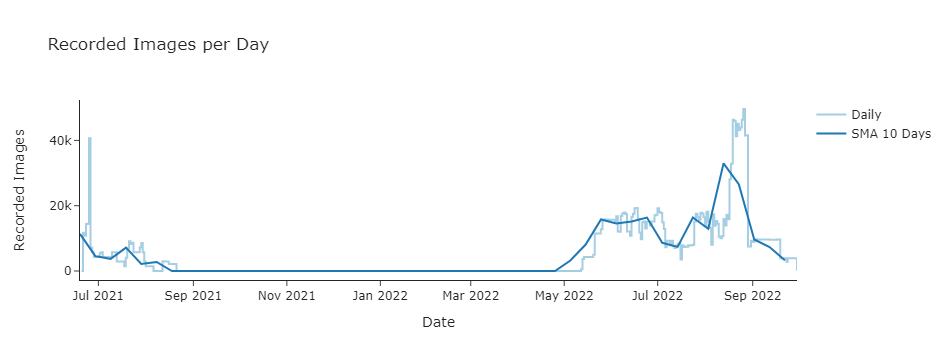

In [85]:
palette = iter(paired_palette)
SMA = 10

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['count'],
    name='Daily',
    line_shape='hv',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA}D').mean().fillna(0)

fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA} Days',
    line_color=next(palette)
))
fig.update_layout(
    title='Recorded Images per Day', 
    template='simple_white',
    xaxis={'title':'Date'}, yaxis={'title':'Recorded Images'}
)

### Active Nodes per day

In [86]:
query_string = """
    SELECT day_time, count(day_time)
    FROM (
        SELECT
            date_trunc('day', prod.files_image.time) as day_time,
            prod.deployments.node_id
        FROM prod.files_image
        LEFT JOIN prod.deployments
        ON prod.files_image.deployment_id = prod.deployments.deployment_id
        GROUP BY day_time, node_id
    ) AS tmp
    GROUP BY day_time
"""

In [87]:
data = sql(query_string)

Retrieved 195 datapoints in 2.287 seconds


In [88]:
data = data.sort_values('day_time')
data = data.set_index('day_time')
data.head(5)

,count
day_time,
2021-06-19 22:00:00,1
2021-06-20 22:00:00,8
2021-06-21 22:00:00,6
2021-06-22 22:00:00,5
2021-06-23 22:00:00,5


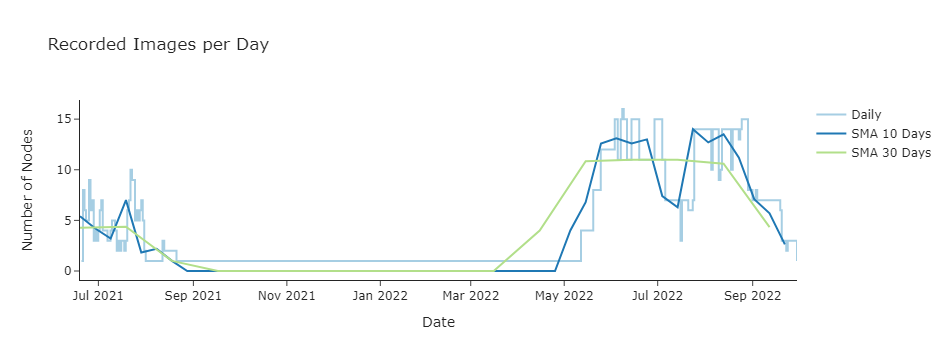

In [90]:
palette = iter(paired_palette)
SMA = 10
SMA2 = 30

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['count'],
    name='Daily',
    line_shape='hv',
    mode='lines',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA}D').mean().fillna(0)
fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA} Days',
    mode='lines',
    line_color=next(palette)
))

tmp = data.resample(f'{SMA2}D').mean().fillna(0)
fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA2} Days',
    mode='lines',
    line_color=next(palette)
))


fig.update_layout(
    title='Recorded Images per Day', 
    template='simple_white',
    xaxis={'title':'Date'}, yaxis={'title':'Number of Nodes'}
)

### Pollinators measured per Day?

In [38]:
query = """
SELECT 
    date_trunc('day', prod.files_image.time) as day_time,
    COUNT(prod.pollinators.pollinator_id)
FROM prod.files_image
LEFT JOIN prod.image_results ON prod.files_image.file_id = prod.image_results.file_id
LEFT JOIN prod.pollinators ON prod.image_results.result_id = prod.pollinators.result_id
GROUP BY day_time
ORDER BY day_time
"""
measured_pollinators = sql(query)
measured_pollinators = measured_pollinators.set_index('day_time')

Retrieved 195 datapoints in 5.105 seconds


In [39]:
measured_pollinators.head(2)

,count
day_time,
2021-06-19 22:00:00,0
2021-06-20 22:00:00,1491


In [40]:
query = """
    SELECT day_time, count(day_time)
    FROM (
        SELECT
            date_trunc('day', prod.files_image.time) as day_time,
            prod.deployments.node_id
        FROM prod.files_image
        LEFT JOIN prod.deployments
        ON prod.files_image.deployment_id = prod.deployments.deployment_id
        GROUP BY day_time, node_id
    ) AS tmp
    GROUP BY day_time
    ORDER BY day_time
"""
active_nodes = sql(query)
active_nodes = active_nodes.set_index('day_time')

Retrieved 195 datapoints in 3.259 seconds


In [41]:
active_nodes.head(2)

,count
day_time,
2021-06-19 22:00:00,1
2021-06-20 22:00:00,8


In [60]:
# check idx equal
for i in range(3):
    rand_idx = np.random.randint(0, len(measured_pollinators))
    assert measured_pollinators.index[rand_idx] == active_nodes.index[rand_idx]

In [62]:
# normalize per node
measured_pollinators['count_per_node'] = measured_pollinators['count'] / active_nodes['count']

In [64]:
measured_pollinators.describe()

,count,count_per_node
count,195.000000,195.000000
mean,561.676923,77.381392
std,751.538685,136.585816
min,0.000000,0.000000
25%,76.000000,11.273810
50%,277.000000,36.857143
75%,767.000000,79.966667
max,4114.000000,931.000000


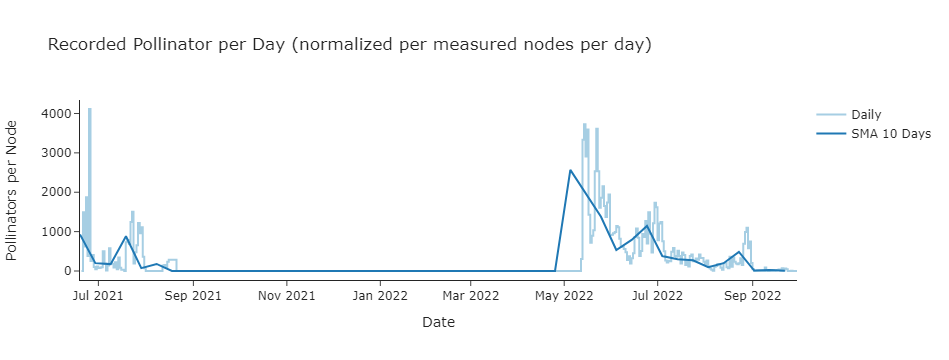

In [94]:
palette = iter(paired_palette)
SMA = 10
SMA2 = 30

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=measured_pollinators.index,
    y=measured_pollinators['count'],
    name='Daily',
    line_shape='hv',
    mode='lines',
    line_color=next(palette)
))

tmp = measured_pollinators.resample(f'{SMA}D').mean().fillna(0)
fig.add_trace(go.Scatter(
    x=tmp.index, 
    y=tmp['count'],
    name=f'SMA {SMA} Days',
    mode='lines',
    line_color=next(palette)
))

fig.update_layout(
    title='Recorded Pollinator per Day (normalized per measured nodes per day)', 
    template='simple_white',
    xaxis={'title':'Date'}, yaxis={'title':'Pollinators per Node'}
)

### Observations per Node over Time

In [101]:
observed_flowers = sql("""
    SELECT 
        date_trunc('day', prod.files_image.time) as time_day,
        prod.deployments.node_id,
        COUNT(prod.flowers.class ) AS obs_flowers
    FROM prod.files_image
    LEFT JOIN prod.deployments ON prod.files_image.deployment_id = prod.deployments.deployment_id
    LEFT JOIN prod.image_results ON prod.files_image.file_id = prod.image_results.file_id
    LEFT JOIN prod.flowers ON prod.image_results.result_id = prod.flowers.result_id
    GROUP BY time_day, node_id
    ORDER BY time_day, node_id
""")

Retrieved 1619 datapoints in 13.951 seconds


In [102]:
observed_flowers = observed_flowers\
    .pivot(index='time_day', columns='node_id', 
           values='obs_flowers')\
    .fillna(0)
observed_flowers.head(2)

node_id,8,14,42,44,45,48,50,53,54,55,...,57,58,61,63,65,67,78,81,86,87
time_day,,,,,,,,,,,,,,,,,,,,,
2021-06-19 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,58,0,0,0,0,0,0,0
2021-06-20 22:00:00,0,0,39924,0,12238,86329,0,0,0,7,...,42032,0,26,0,4,0,0,0,0,0


In [103]:
observed_flowers['mean'] = np.mean(observed_flowers.to_numpy(), axis=1)

In [121]:
palette = px.colors.colorbrewer.Greys

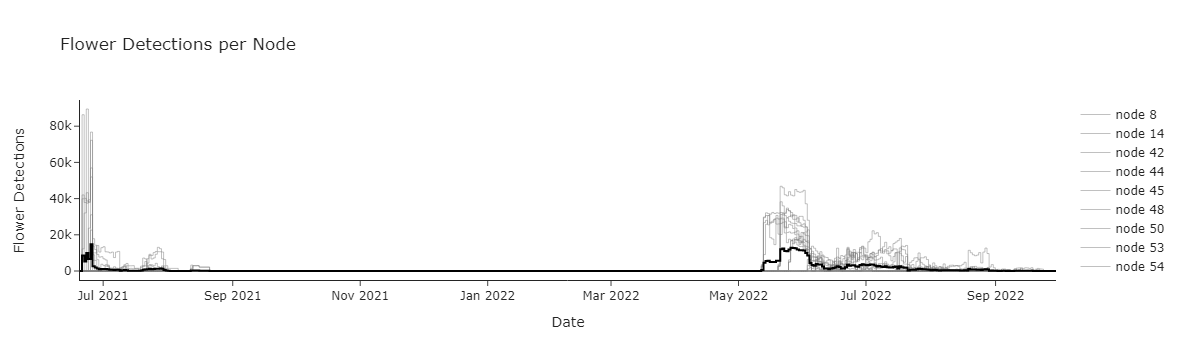

In [165]:
fig = go.Figure()
colors = iter(palette)
for col in observed_flowers.columns:
    if col == 'mean':
        fig.add_trace(go.Scatter(
            x=observed_flowers.index, 
            y=observed_flowers[col],
            name=f'node {col}',
            line_shape='hv',
            line=dict(
                color="black", width=2
            )
        ))
    else:
        fig.add_trace(go.Scatter(
            x=observed_flowers.index, 
            y=observed_flowers[col],
            name=f'node {col}',
            line_shape='hv',
            line=dict(
                color="grey", width=.5
            )
        ))

fig.update_layout(
    title='Flower Detections per Node', 
    template='simple_white',
    xaxis={'title':'Date'}, yaxis={'title':'Flower Detections'}
)
fig.show()

In [152]:
observed_pollinators = sql("""
    SELECT 
        date_trunc('day', prod.files_image.time) as time_day,
        prod.deployments.node_id,
        COUNT(prod.pollinators.class ) AS obs_pollinators
    FROM prod.files_image
    LEFT JOIN prod.deployments ON prod.files_image.deployment_id = prod.deployments.deployment_id
    LEFT JOIN prod.image_results ON prod.files_image.file_id = prod.image_results.file_id
    LEFT JOIN prod.flowers ON prod.image_results.result_id = prod.flowers.result_id
    INNER JOIN prod.pollinators ON prod.flowers.flower_id = prod.pollinators.flower_id
    GROUP BY time_day, node_id
    ORDER BY time_day, node_id
""")

Retrieved 1044 datapoints in 2.534 seconds


In [154]:
observed_pollinators = observed_pollinators\
    .pivot(index='time_day', columns='node_id', 
           values='obs_pollinators')\
    .fillna(0)
observed_flowers.head(2)

node_id,8,14,42,44,45,48,50,53,54,55,...,58,61,63,65,67,78,81,86,87,mean
time_day,,,,,,,,,,,,,,,,,,,,,
2021-06-19 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,58,0,0,0,0,0,0,0,2.761905
2021-06-20 22:00:00,0,0,39924,0,12238,86329,0,0,0,7,...,0,26,0,4,0,0,0,0,0,8599.0


In [155]:
observed_pollinators['mean'] = np.mean(observed_pollinators.to_numpy(), axis=1)

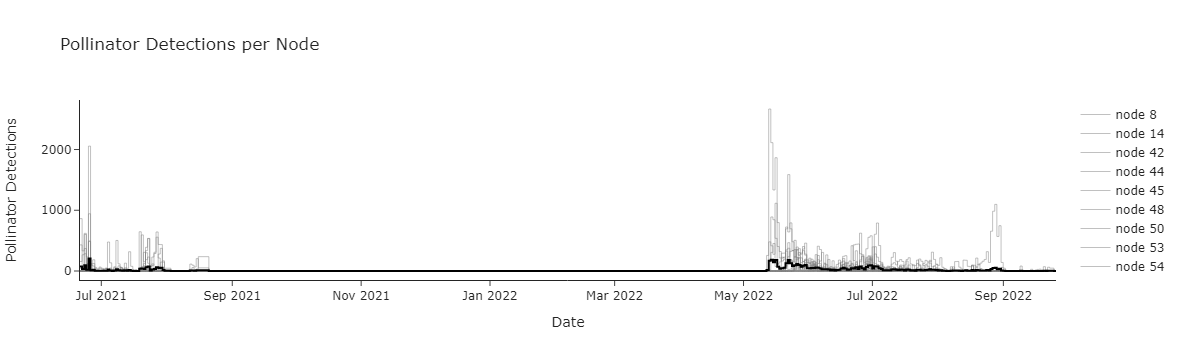

In [163]:
fig = go.Figure()
colors = iter(palette)
for col in observed_pollinators.columns:
    if col == 'mean':
        fig.add_trace(go.Scatter(
            x=observed_pollinators.index, 
            y=observed_pollinators[col],
            name=f'node {col}',
            line_shape='hv',
            line=dict(
                color="black", width=2
            )
        ))
    else:
        fig.add_trace(go.Scatter(
            x=observed_pollinators.index, 
            y=observed_pollinators[col],
            name=f'node {col}',
            line_shape='hv',
            line=dict(
                color="grey", width=.5
            )
        ))

fig.update_layout(
    title='Pollinator Detections per Node', 
    template='simple_white',
    xaxis={'title':'Date'}, yaxis={'title':'Pollinator Detections'}
)
fig.show()

### Observed Pollinators per Day

In [34]:
data = sql("""
    SELECT * 
    FROM (
    SELECT 
        date_trunc('day', files_image.time) as day,
        pollinators.class, count(pollinators.class)
        from prod.files_image
        LEFT JOIN prod.image_results
        ON files_image.file_id = image_results.file_id
        LEFT JOIN prod.pollinators
        ON image_results.result_id = pollinators.result_id
        GROUP BY day, pollinators.class
        ORDER BY day
    ) AS tmp
    WHERE tmp.class IS NOT NULL
""")

Retrieved 742 datapoints in 2.049 seconds


In [36]:
data.head(5)

,day,class,count
0,2021-06-20 22:00:00,fliege,824
1,2021-06-20 22:00:00,honigbiene,6
2,2021-06-20 22:00:00,schwebfliege,29
3,2021-06-20 22:00:00,wildbiene,632
4,2021-06-21 22:00:00,fliege,240


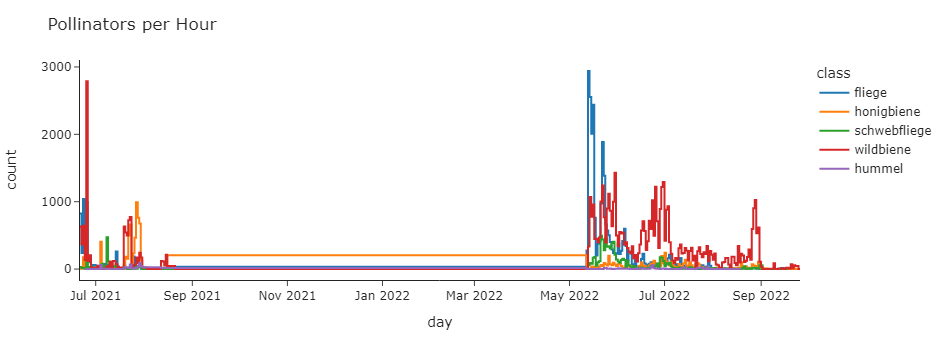

In [86]:
fig = px.line(data_frame=data, x='day', y='count', color='class', 
              line_shape='hv', template='simple_white')
fig.update_layout(title='Pollinators per Hour')
fig.show()

### Pollinators distributed over Weeks and Days (Heatmap)

In [53]:
res.sort_values('time')

,time,class,count
303976,2021-06-20 14:00:00,None,0
589932,2021-06-20 16:00:00,None,0
321811,2021-06-21 08:00:00,None,0
761967,2021-06-21 08:00:00,None,0
300510,2021-06-21 08:00:00,None,0
...,...,...,...
87415,2022-09-30 08:00:00,None,0
587953,2022-09-30 08:00:00,None,0
30107,2022-09-30 08:00:00,None,0
560866,2022-09-30 08:00:00,None,0


In [48]:
res = res.sort_values(by='time').reset_index(drop=True)
res = res.dropna(axis=0)
res.head(20)

,time,class,count
0,2021-06-21 08:00:00,fliege,1
1,2021-06-21 08:00:00,wildbiene,1
2,2021-06-21 08:00:00,wildbiene,1
3,2021-06-21 08:00:00,fliege,1
4,2021-06-21 08:00:00,fliege,1
5,2021-06-21 08:00:00,wildbiene,1
6,2021-06-21 08:00:00,wildbiene,1
7,2021-06-21 08:00:00,fliege,1
8,2021-06-21 08:00:00,wildbiene,1
9,2021-06-21 08:00:00,wildbiene,1


### Per Node Statistics of Pollinators

### Amount of Recorded Flowers per Node over Time